# Stochastic Modeling

In [5]:
import os
import math
import pandas as pd
import numpy as np
import random
import decimal
import scipy.linalg
from scipy.stats import norm
import numpy.random as nrand
import matplotlib.pyplot as plt
%matplotlib inline

In [433]:
# Getting the dataset
df = pd.read_csv("SPY.csv",index_col="Date", parse_dates=True)
spy = pd.DataFrame({'SPY':df['Adj Close']})

# Month format ("%yyyy%/%mm%/%dd%%")
start_date = "2017-12-27"
end_date = "2018-12-28"
dates = pd.date_range(start_date,end_date)

prices = pd.DataFrame(index=dates)
prices = prices.join(spy, how='inner')

returns = np.log(prices / prices.shift(1)).iloc[1:]

In [554]:
# Parameters

# General
simulations = 2500 # number of simulations
m_periods=21 # number of periods for each simulation
log_returns = returns['SPY'] # log returns for the SPY
last_value = prices.iloc[-1] # last price recorded in the SPY
time_deviation = math.sqrt(1/252) * log_returns.std() # 

# Geometric Brownian Motion
mu = log_returns.mean() # average of log returns 
var = log_returns.var() # variance of log returns
sigma = log_returns.std() # standard deviation/ volatility of log returns

# Jump Difussion Model
j_lambda = 0.00125 # probability of a jump happening at each point in time
j_sigma=0.001 # volatility of the jump size
j_mu=-0.15 # average Jump size

random_seed = 7

# Brownian Motion

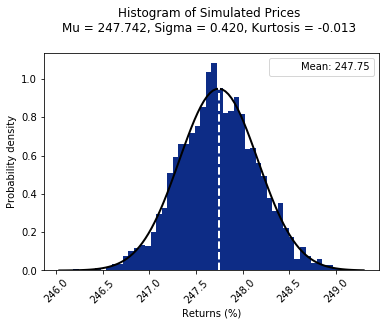

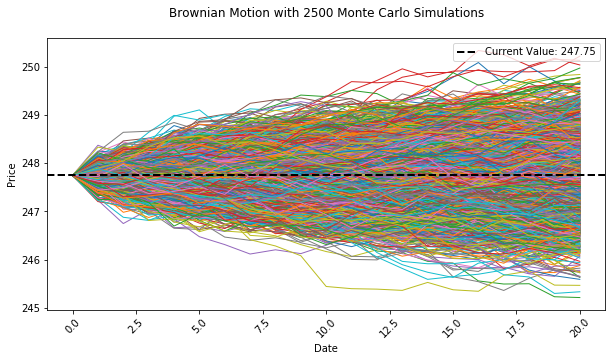

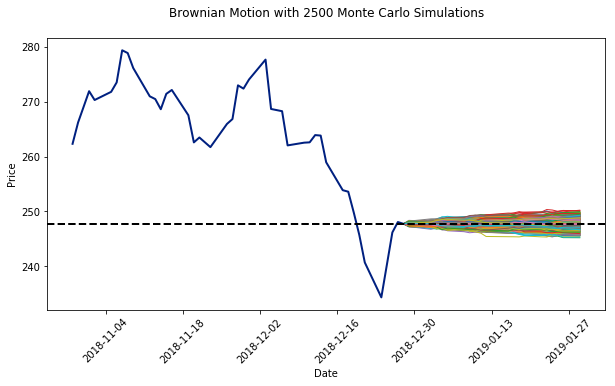

In [555]:
def Brownian_Motion(seed=random_seed,periods=m_periods,annualsimulations=simulations,plot=True):
    
    np.random.seed(seed)
    
    # Winer Process
    z = np.random.normal(loc=0, scale= time_deviation, size=(periods,simulations))

    # Convert to daily returns
    daily_returns = np.exp(z)

    # Convert to daily prices
    price_list = np.zeros_like(daily_returns)

    price_list[0] = last_value

    for i in range(1, periods):
        price_list[i] = price_list[i - 1] * daily_returns[i-1]

    # Storing simulations into future dates
    forward_time = pd.DataFrame(log_returns.index[:periods], columns=['Date'])
    forward_time['Date'] = forward_time + pd.DateOffset(years=1)
    try:
        price_simulations = pd.DataFrame(price_list,index=forward_time)
    except ValueError:
        price_simulations = pd.DataFrame(price_list)
    
    price_simulations_t = pd.DataFrame(price_list)
    
    
    # Graphing histogram of simulated prices
    price_array = price_simulations.mean().sort_values(ascending=True)
    
    mu_hist = price_array.mean() 
    sigma_hist = price_array.std()  
    kurtosis = price_array.kurtosis()
    skewness = price_array.skew()
    num_bins = int(np.sqrt(simulations))

    fig, ax = plt.subplots()
    n, bins, patches = ax.hist(price_array, num_bins, density=1,color="#002080",label='',alpha=0.95)

    xmin, xmax = plt.xlim()
    x = np.linspace(xmin, xmax, 100)
    p = norm.pdf(x, mu_hist, sigma_hist)
    plt.plot(x, p, 'k', linewidth=2)
    
    plt.xlabel('Returns (%)')
    plt.xticks(rotation=45)
    plt.yticks()
    plt.ylabel('Probability density')
    ax.set_title("Histogram of Simulated Prices \nMu = %.3f, Sigma = %.3f, Kurtosis = %.3f \n" % (mu_hist,sigma_hist,kurtosis), fontsize=12)
    plt.axvline(x=float(last_value), color='w', linestyle='dashed',linewidth=2, label = 'Mean: ' + str(round(float(last_value),3)))
    ax.set_facecolor('w')
    plt.legend(loc="upper right")
    
    # Graphing simulations in sequence
    plt.figure(figsize=(10,5))
    plt.plot(price_simulations_t,linestyle='-',linewidth=1)
    plt.axhline(y=float(last_value), color='k', linestyle='dashed',linewidth=2,label = 'Current Value: ' + str(round(float(last_value),3)))
    
    title = "Brownian Motion with " + str(simulations) + " Monte Carlo Simulations\n"
    plt.title(title)
    plt.xlabel('Time')
    plt.ylabel('Price')
    plt.xticks(rotation=45)
    plt.legend(loc="upper right")
    
    if plot:
        
        # Back-test and front-test time-series:
        plt.figure(figsize=(10,5))
        plt.plot(price_simulations,linestyle='-',linewidth=1)
        plt.plot(prices[-periods*2:], color="#002080",linewidth=2,label="SPY")
        plt.axhline(y=float(last_value), color='k', linestyle='dashed',linewidth=2,label = 'Current Value: ' + str(round(float(last_value),3)))
        
        title = "Brownian Motion with " + str(simulations) + " Monte Carlo Simulations\n"
        plt.title(title)
        plt.xlabel('Date')
        plt.ylabel('Price')
        plt.xticks(rotation=45)
        #plt.legend(loc="upper right")
        #plt.savefig('Forwardtest.png', dpi=300,bbox_inches='tight')
        
Brownian_Motion()


# Geometric Brownian Motion

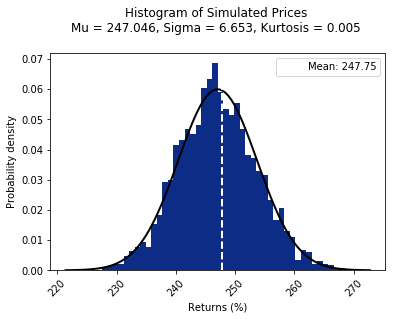

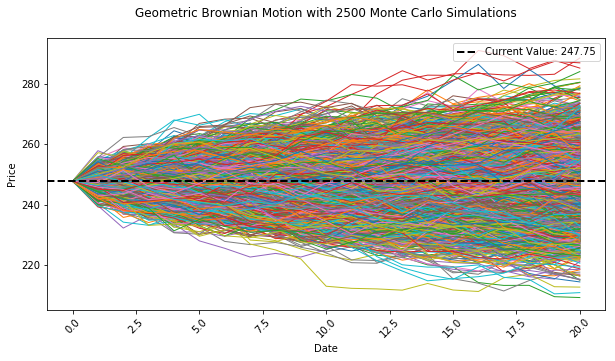

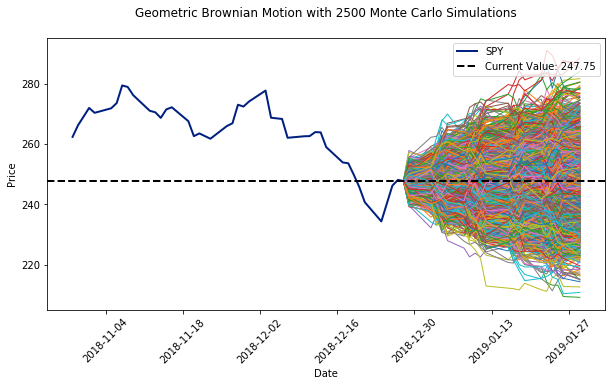

In [556]:
def Geometric_Brownian_Motion(seed=random_seed,periods=m_periods,annualsimulations=simulations,plot=True):
    
    np.random.seed(seed)
    
    # Geometric Brownian motion 
    drift = mu - (0.5*var)
    
    z = np.random.normal(loc=0, size=(periods,simulations))
    
    geom =  drift + sigma * z
    
    # Convert to daily returns
    daily_returns = np.exp(geom)
    
    # Convert to prices
    price_list = np.zeros_like(daily_returns)

    price_list[0] = last_value
    
    for i in range(1, periods):
        price_list[i] = price_list[i - 1] * daily_returns[i-1]
    
    # Storing simulations into future dates
    forward_time = pd.DataFrame(log_returns.index[:periods], columns=['Date'])
    forward_time['Date'] = forward_time + pd.DateOffset(years=1)
    try:
        price_simulations = pd.DataFrame(price_list,index=forward_time)
    except ValueError:
        price_simulations = pd.DataFrame(price_list)
    price_simulations_t = pd.DataFrame(price_list)
    
    # Graphing histogram of simulated prices
    price_array = price_simulations.mean().sort_values(ascending=True)
    
    mu_hist = price_array.mean() 
    sigma_hist = price_array.std()  
    kurtosis = price_array.kurtosis()
    skewness = price_array.skew()
    num_bins = int(np.sqrt(simulations))

    fig, ax = plt.subplots()
    n, bins, patches = ax.hist(price_array, num_bins, density=1,color="#002080",label='',alpha=0.95)

    xmin, xmax = plt.xlim()
    x = np.linspace(xmin, xmax, 100)
    p = norm.pdf(x, mu_hist, sigma_hist)
    plt.plot(x, p, 'k', linewidth=2)
    
    plt.xlabel('Returns (%)')
    plt.xticks(rotation=45)
    plt.yticks()
    plt.ylabel('Probability density')
    ax.set_title("Histogram of Simulated Prices \nMu = %.3f, Sigma = %.3f, Kurtosis = %.3f \n" % (mu_hist,sigma_hist,kurtosis), fontsize=12)
    plt.axvline(x=float(last_value), color='w', linestyle='dashed',linewidth=2, label = 'Mean: ' + str(round(float(last_value),3)))
    ax.set_facecolor('w')
    plt.legend(loc="upper right")
    
    # Graphing simulations in sequence
    plt.figure(figsize=(10,5))
    plt.plot(price_simulations_t,linestyle='-',linewidth=1)
    plt.axhline(y=float(last_value), color='k', linestyle='dashed',linewidth=2,label = 'Current Value: ' + str(round(float(last_value),3)))
    
    title = "Geometric Brownian Motion with " + str(simulations) + " Monte Carlo Simulations\n"
    plt.title(title)
    plt.xlabel('Time')
    plt.ylabel('Price')
    plt.xticks(rotation=45)
    plt.legend(loc="upper right")
    
    if plot:
        
        # Back-test and front-test time-series:
        plt.figure(figsize=(10,5))
        plt.plot(price_simulations,linestyle='-',linewidth=1)
        plt.plot(prices[-periods*2:], color="#002080",linewidth=2,label="SPY")
        plt.axhline(y=float(last_value), color='k', linestyle='dashed',linewidth=2,label = 'Current Value: ' + str(round(float(last_value),3)))
        
        title = "Geometric Brownian Motion with " + str(simulations) + " Monte Carlo Simulations\n"
        plt.title(title)
        plt.xlabel('Date')
        plt.ylabel('Price')
        plt.xticks(rotation=45)
        plt.legend(loc="upper right")
    
Geometric_Brownian_Motion()


# Merton Jump Diffusion Model

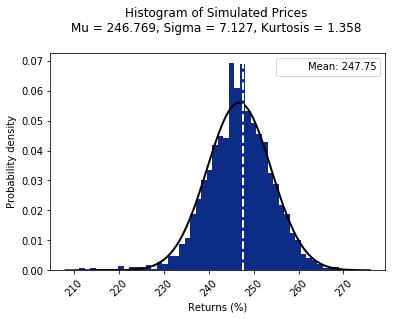

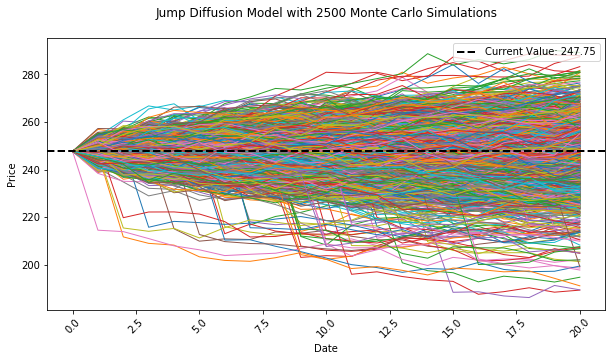

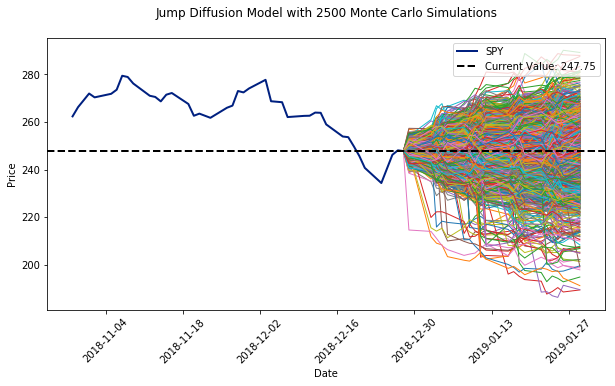

In [557]:
def jump_diff(seed=random_seed):
    
    np.random.seed(seed)
    
    jump_sizes = []
    s_n = time = 0
    small_lamda = -(1.0 / j_lambda)
    for k in range(0, m_periods):
        jump_sizes.append(0.0)
    while s_n < m_periods:
        s_n += small_lamda * math.log(random.uniform(0, 1))
        for j in range(0, m_periods):
            if time * time_deviation <= s_n * time_deviation <= (j + 1) * time_deviation:
                jump_sizes[j] += np.random.normal(j_mu, j_sigma)
                break
        time += 1
        
    return jump_sizes

def Jump_Diffussion_Model(seed=random_seed,periods=m_periods,annualsimulations=simulations,date=True):
    
    np.random.seed(seed)
    
    # Geometric Brownian motion 
    drift = mu - (0.5*var)
    
    z = np.random.normal(loc=0, size=(periods,simulations))
    
    geom =  drift + sigma * z
    
    # Jumpt Diffusion Process
    jump_diffusion = np.zeros_like(z)

    jump_diffusion[:,0] = jump_diff()

    for i in range(1, simulations):
        jump_diffusion[:,i] = jump_diff()
        
    jump_diffusion_model = np.add(jump_diffusion,geom)
    
    # Convert to daily returns
    daily_returns = np.exp(jump_diffusion_model)
    
    # Convert to prices
    price_list = np.zeros_like(daily_returns)

    price_list[0] = last_value
    
    for i in range(1, periods):
        price_list[i] = price_list[i - 1] * daily_returns[i]
    
    # Storing simulations into future dates
    forward_time = pd.DataFrame(log_returns.index[:periods], columns=['Date'])
    forward_time['Date'] = forward_time + pd.DateOffset(years=1)
    price_simulations = pd.DataFrame(price_list,index=forward_time)
    price_simulations_t = pd.DataFrame(price_list)
    
    # Graphing histogram of simulated prices
    price_array = price_simulations.mean().sort_values(ascending=True)
    
    mu_hist = price_array.mean() 
    sigma_hist = price_array.std()  
    kurtosis = price_array.kurtosis()
    skewness = price_array.skew()
    num_bins = int(np.sqrt(simulations))

    fig, ax = plt.subplots()
    n, bins, patches = ax.hist(price_array, num_bins, density=1,color="#002080",label='',alpha=0.95)

    xmin, xmax = plt.xlim()
    x = np.linspace(xmin, xmax, 100)
    p = norm.pdf(x, mu_hist, sigma_hist)
    plt.plot(x, p, 'k', linewidth=2)
    
    plt.xlabel('Returns (%)')
    plt.xticks(rotation=45)
    plt.yticks()
    plt.ylabel('Probability density')
    ax.set_title("Histogram of Simulated Prices \nMu = %.3f, Sigma = %.3f, Kurtosis = %.3f \n" % (mu_hist,sigma_hist,kurtosis), fontsize=12)
    plt.axvline(x=float(last_value), color='w', linestyle='dashed',linewidth=2, label = 'Mean: ' + str(round(float(last_value),3)))
    ax.set_facecolor('w')
    plt.legend(loc="upper right")
    
    # Graphing simulations in sequence
    plt.figure(figsize=(10,5))
    plt.plot(price_simulations_t,linestyle='-',linewidth=1)
    plt.axhline(y=float(last_value), color='k', linestyle='dashed',linewidth=2,label = 'Current Value: ' + str(round(float(last_value),3)))
    
    title = "Jump Diffusion Model with " + str(simulations) + " Monte Carlo Simulations\n"
    plt.title(title)
    plt.xlabel('Time')
    plt.ylabel('Price')
    plt.xticks(rotation=45)
    plt.legend(loc="upper right")
    
    if date:
        
        # Graphing simulations in date time:
        plt.figure(figsize=(10,5))
        plt.plot(price_simulations,linestyle='-',linewidth=1)
        plt.plot(prices[-periods*2:], color="#002080",linewidth=2,label="SPY")
        plt.axhline(y=float(last_value), color='k', linestyle='dashed',linewidth=2,label = 'Current Value: ' + str(round(float(last_value),3)))
        
        title = "Jump Diffusion Model with " + str(simulations) + " Monte Carlo Simulations\n"
        plt.title(title)
        plt.xlabel('Date')
        plt.ylabel('Price')
        plt.xticks(rotation=45)
        plt.legend(loc="upper right")
    
    
Jump_Diffussion_Model()